# Regression Model to Predict Affinity from Protein Sequences using AlphaSeq Dataset
Andrew Kiruluta, 04/02/2023


In [630]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(5)

In [631]:
fields = ["sequence_a","Kd","Kd_lower_bound","Kd_upper_bound"]
df= pd.read_csv('data/20230331_pembro_SSMplus_AlphaSeq_data.csv', usecols=fields)
df.head(5)

,sequence_a,Kd,Kd_lower_bound,Kd_upper_bound
0,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.241963,1.191959,1.291968
1,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.379355,1.318349,1.440361
2,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.152859,1.120984,1.184735
3,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.123487,1.082745,1.164230
4,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.161713,1.128016,1.195410


In [608]:
# statics of the affinity values
df.describe()

,Kd,Kd_lower_bound,Kd_upper_bound
count,29358.000000,30049.000000,29358.000000
mean,2.870087,2.512373,3.244432
std,0.802777,0.611098,1.018285
min,0.109426,0.088698,0.130155
25%,2.586133,2.372563,2.794151
50%,3.032297,2.666249,3.393826
75%,3.386192,2.888457,3.891682
max,4.912977,3.965893,5.934850


* We will keep the lower and upper bounds of affinities for comparison to inference spread within these limits.
* The affinity column which is our target has no infinities (we will check for nulls later) but the range between min/max is significant. We need to place the target on the same scale for the regression task.

In [609]:
# look for missing values
df.isnull().sum()

sequence_a          0
Kd                691
Kd_lower_bound      0
Kd_upper_bound    691
dtype: int64

691 protein sequences have NULL values. Without domain knowledge or background on the data, it makes sense to purge rows where Kd values are missing

In [610]:
df = df[df['Kd'].notna()]  # take only rows where Kd is not NaN, purge NaNs

# Analyzing Protein Sequence Statistics:
Protein sequence statistics visualizations are simple but very insightful: 
They include:

sequence frequency analysis,
sequence length analysis,
average sequence length analysis,
These really help explore the fundamental characteristics of the protein sequence data.

To do so, we will be mostly be using histograms (continuous data) and bar charts (categorical data).

First, I’ll take a look at the number of characters present in each sentence. This can give us a rough idea about the news headline length.

<AxesSubplot:>

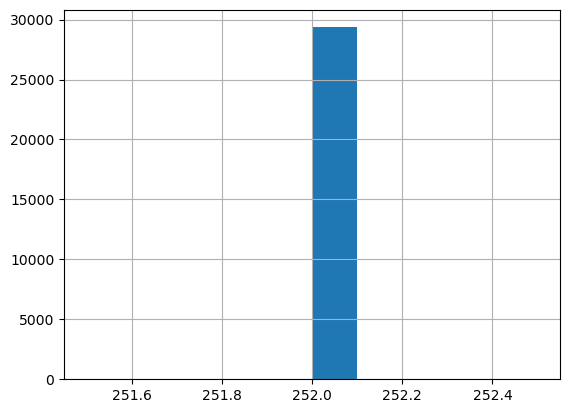

In [611]:
df['sequence_a'].str.len().hist()

In [612]:
df['sequence_a'].str.len().describe()

count    29358.0
mean       252.0
std          0.0
min        252.0
25%        252.0
50%        252.0
75%        252.0
max        252.0
Name: sequence_a, dtype: float64

All the protein sequences are of the same length. 

In [615]:
df['sequence_a'].nunique()

29199

In [616]:
print("number of repeated protein sequences in dataset: ", df.shape[0] - df['sequence_a'].nunique())

number of repeated protein sequences in dataset:  159


In [617]:
duplicate = df[df.duplicated('sequence_a')]
duplicate

,sequence_a,Kd,Kd_lower_bound,Kd_upper_bound
1,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.379355,1.318349,1.440361
2,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.152859,1.120984,1.184735
3,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.123487,1.082745,1.164230
4,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.161713,1.128016,1.195410
5,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.225249,1.183534,1.266964
...,...,...,...,...
29093,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,2.920335,2.664129,3.176542
29094,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,2.828503,2.450093,3.206913
29096,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,2.794269,2.499184,3.089354
29097,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,2.515867,2.321546,2.710188


In [618]:
# an example of a sequence that appears twice in the dataset but with different affinity values 
# in contradictory Kd upper and lower bounds
df['sequence_a'][0] == df['sequence_a'][1]

True

# Inconsistent Repeated Protein Sequences in the Data:
We see that there are 166 repeated protein sequences with inconsistent affinity values and unfortunately, the upper and lower affinity bounds are also different for each respective repeated sequence pairs. I would forgive these inconsistences if the affinity values fell within consistent bounds but alas they do not! This makes it hard to trust using these rows in the model as they are not self consistent. We will therefore purge them from the training set.

In [619]:
df2 = df.drop_duplicates('sequence_a')
df2.shape
df2.to_csv('data/20230331_pembro_SSMplus_AlphaSeq_data_unique.csv', index=False)

array([[<AxesSubplot:title={'center':'Kd'}>]], dtype=object)

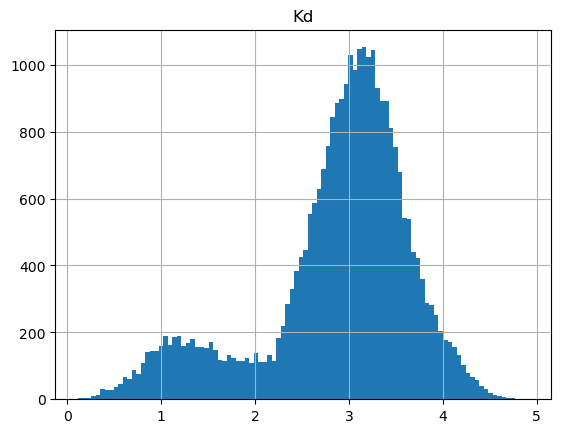

In [620]:
df.hist(column='Kd', bins=100)

https://towardsdatascience.com/quantile-regression-from-linear-models-to-trees-to-deep-learning-af3738b527c3
https://medium.com/the-artificial-impostor/quantile-regression-part-1-e25bdd8d9d43
https://medium.com/the-artificial-impostor/quantile-regression-part-2-6fdbc26b2629
https://www.kaggle.com/code/asal73/eda-quantile-regression-lightgbm-pytorch
https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html




The response variable (affinity Kd) displays a bimodal distribution, suggesting there are different populations in my data.

It is true that regression does not make an assumption about the distribution of the dependent variable (it assumes things about the errors). But just because a model doesn't violate assumptions doesn't mean it is a good model. Remember that the usual regression models are models of the mean. Often, with a bimodal or multimodal response, the mean is not interesting. Often you would not use it as a measure of location -- in fact, there might not be a single good measure of location. So, if you aren't interested in the mean, why model it?

One way around this is quantile regression. Here you could regress on the quantiles that are peaks of your combined data.

# Custom Tokenizer with Torch Embedding Layer
my M1 Pro chip (arm64) is not supported by the pretrained BertTokenizer :()

In [533]:
MAX_PROT_LEN = 252
tok_emb = nn.Embedding(MAX_PROT_LEN, 1)

In [534]:
# AA_vocab and pos_vocab were used to train protein sequence activity oracle
AA_map = {'<PAD>': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4,
            'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10,
            'M': 11,'N': 12, 'P': 13, 'Q': 14, 'R': 15,
            'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}

MAX_PROT_LEN = 252
VOCAB_SIZE = len(AA_map)
#tok_emb = nn.Embedding(VOCAB_SIZE, 1)

def get_protein_encoding(seq):
    encoding = [0]*MAX_PROT_LEN
    try:
        if len(seq) > MAX_PROT_LEN:
            seq = seq[:MAX_PROT_LEN]
        for i, aa in enumerate(seq):
            try:
                encoding[i] = AA_map[aa] 
            except Exception as e:
                encoding[i] = 0
    except Exception as e:
        pass
    return encoding

def embedding(seq):
    return tok_emb(torch.tensor(seq,dtype=torch.long)) 

def embedding2(seq):
    return tok_emb(torch.tensor(seq,dtype=torch.long)).detach().numpy() 


In [535]:
seq = embedding(get_protein_encoding(df2['sequence_a'][0]))
print(seq)

tensor([[-0.7308],
        [ 0.5189],
        [ 2.7799],
        [-0.5849],
        [-0.3364],
        [-0.5849],
        [-1.3527],
        [-0.3364],
        [-0.5849],
        [ 2.7799],
        [-0.1307],
        [-0.3364],
        [ 2.0194],
        [-0.3364],
        [-0.0190],
        [-0.0190],
        [-0.4194],
        [-0.1307],
        [ 0.5189],
        [ 2.7799],
        [-0.3364],
        [-0.0190],
        [-0.3364],
        [ 2.7799],
        [-1.7119],
        [-0.0190],
        [ 0.5189],
        [ 2.7799],
        [-0.1307],
        [-0.1297],
        [ 1.2220],
        [-0.2686],
        [ 1.2220],
        [ 0.9879],
        [-0.1297],
        [-0.1297],
        [-0.7308],
        [-0.1297],
        [-0.9651],
        [-0.3364],
        [-0.7823],
        [-0.5849],
        [ 0.5189],
        [-0.4194],
        [-0.1307],
        [-0.5849],
        [-0.1307],
        [-1.3527],
        [ 2.0194],
        [-0.9651],
        [-0.7308],
        [-0.1307],
        [-0.

In [536]:
df2.head(5)

,sequence_a,Kd,Kd_lower_bound,Kd_upper_bound
0,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.241963,1.191959,1.291968
50,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFNYYMYWVRQAPGQG...,3.751155,3.115660,4.386650
51,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFYYMYWVRQAPGQGL...,2.906238,2.620341,3.192135
52,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYWVRQAPGQGL...,3.230485,2.770773,3.690198
53,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,3.045252,2.685666,3.404839


In [537]:
df3 = df2.copy()
#df3['embedding'] = df3['sequence_a'].apply(lambda x: embedding2(get_protein_encoding(x)).flatten())
df3['embedding'] = df3['sequence_a'].apply(lambda x: get_protein_encoding(x))
df3.to_csv('data/20230331_pembro_SSMplus_AlphaSeq_data_unique_embedding.csv', index=False)
df3.head(5)

,sequence_a,Kd,Kd_lower_bound,Kd_upper_bound,embedding
0,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.241963,1.191959,1.291968,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."
50,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFNYYMYWVRQAPGQG...,3.751155,3.115660,4.386650,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."
51,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFYYMYWVRQAPGQGL...,2.906238,2.620341,3.192135,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."
52,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYWVRQAPGQGL...,3.230485,2.770773,3.690198,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."
53,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,3.045252,2.685666,3.404839,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."


In [538]:
df3['embedding']

0        [11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,...
50       [11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,...
51       [11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,...
52       [11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,...
53       [11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,...
                               ...                        
30044    [11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,...
30045    [11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,...
30046    [11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,...
30047    [11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,...
30048    [11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,...
Name: embedding, Length: 29199, dtype: object

In [415]:
np.array(df3['embedding']).shape

(29883,)

In [411]:
pd.DataFrame(np.array(df3['embedding']))

,0
0,"[-1.7766757, -0.11185568, 2.521986, -0.2655836..."
1,"[-1.7766757, -0.11185568, 2.521986, -0.2655836..."
2,"[-1.7766757, -0.11185568, 2.521986, -0.2655836..."
3,"[-1.7766757, -0.11185568, 2.521986, -0.2655836..."
4,"[-1.7766757, -0.11185568, 2.521986, -0.2655836..."
...,...
29878,"[-1.7766757, -0.11185568, 2.521986, -0.2655836..."
29879,"[-1.7766757, -0.11185568, 2.521986, -0.2655836..."
29880,"[-1.7766757, -0.11185568, 2.521986, -0.2655836..."
29881,"[-1.7766757, -0.11185568, 2.521986, -0.2655836..."


# LSTM Regression Model

In [416]:
df3 = pd.read_csv('data/20230331_pembro_SSMplus_AlphaSeq_data_unique_embedding.csv')
df_train = df3.sample(frac=0.8,random_state=200)
df_test = df3.drop(df_train.index)

In [417]:
class ProteinDataset(Dataset):
 
  def __init__(self,df,transform=embedding):
    self.df = df
    self.transform = transform
  def __len__(self):
    return len(self.df)
   
  def __getitem__(self,idx):
      self.x = self.df.loc[idx,"embedding"]
      self.y = self.df.loc[idx,"Kd"]
      self.x = torch.tensor(ast.literal_eval(self.x),dtype=torch.long)
      self.x = self.transform(self.x).flatten()
      self.y = torch.tensor(self.y,dtype=torch.float32)
      return self.x,self.y

In [418]:
df_train.head(5)

,sequence_a,Kd,Kd_lower_bound,Kd_upper_bound,embedding
232,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,3.719982,3.218770,4.221194,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."
12859,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,3.585643,2.950148,4.221138,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."
5174,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,0.802008,0.767586,0.836431,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."
5287,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTWYYMYWVRHAPGQ...,3.874563,3.239068,4.510058,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."
21050,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,3.575605,3.019101,4.132109,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."


In [419]:
train_dataset = ProteinDataset(df_train)
X, y =train_dataset[0]
print(X)
#print(y)

tensor([-1.7767, -0.1119,  2.5220, -0.2656, -0.2601, -0.2656,  0.0541, -0.2601,
        -0.2656,  2.5220,  1.3211, -0.2601, -0.7494, -0.2601, -1.8593, -1.8593,
         0.5810,  1.3211, -0.1119,  2.5220, -0.2601, -1.8593, -0.2601,  2.5220,
        -0.2102, -1.8593, -0.1119,  2.5220,  1.3211,  0.4993, -0.7675,  0.8838,
        -0.7675, -0.4437,  0.4993,  0.4993, -1.7767,  0.4993, -0.4379, -0.2601,
         0.4147, -0.2656, -0.1119,  0.5810,  1.3211, -0.2656,  1.3211,  0.0541,
        -0.7494, -0.4379, -1.7767,  1.3211,  1.3211, -1.4731, -0.4437,  0.5810,
         2.5220, -0.4437,  1.3211,  1.3211, -0.7675, -0.4437,  0.8838, -0.4437,
        -0.7494, -1.8593,  0.8838, -1.8593, -0.4437,  0.4147, -0.2601, -0.7675,
         0.0541, -0.7675, -0.7675,  0.9292,  2.5220,  2.5220, -0.7675, -0.7675,
        -0.7675, -0.1119,  0.4993, -1.7767, -0.7494,  0.0541, -1.8593,  2.5220,
         0.0541, -0.2656,  0.8838,  0.9292,  0.9292, -0.7675, -0.1119, -0.2601,
         0.4993,  0.4993, -0.2102, -0.11

/var/folders/hd/rt0tld6j7pvczxlpknvs6wn00000gn/T/ipykernel_8134/488224492.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return tok_emb(torch.tensor(seq,dtype=torch.long))


https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/bidirectional_recurrent_neural_network/main.py

https://github.com/CrosstabKite/lstm-forecasting/blob/master/lstm_forecasting.ipynb


In [455]:
torch.manual_seed(101)

batch_size = 1

train_dataset = ProteinDataset(df_train)
test_dataset = ProteinDataset(df_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [456]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, features, hidden_units):
        super().__init__()
        self.features = features  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = 1
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

# Training for Bidirectional LSTM

In [451]:
learning_rate = 5e-5
num_hidden_units = 1

model = ShallowRegressionLSTM(features=252, hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [459]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
    #for X, y, in enumerate(train_dataset):
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")

In [ ]:
#print("Untrained test\n--------")
#test_model(test_loader, model, loss_function)
#print()

for ix_epoch in range(2):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    #test_model(test_loader, model, loss_function)
    print()

# Streaming ML with River Torch

In [655]:
df3 = pd.read_csv('data/20230331_pembro_SSMplus_AlphaSeq_data_unique_embedding.csv')

In [656]:
# scale target Kd column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df3[['Kd']] = scaler.fit_transform(df3[['Kd']])
df_train = df3.sample(frac=0.8,random_state=200)
df_test = df3.drop(df_train.index)

In [657]:
df_train.head(5)

,sequence_a,Kd,Kd_lower_bound,Kd_upper_bound,embedding
7931,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFENYYMYWVRQAPGQ...,0.186461,0.971318,1.038884,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."
26860,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFNNYYMYWVRQAPGQ...,0.055731,0.360055,0.394214,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."
5727,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,0.685736,2.846888,3.959896,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."
14067,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWWRQAPGQ...,0.129232,0.707022,0.753379,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."
5356,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYRYWVRQAPGQ...,0.795592,3.168784,4.693398,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."


# Model Training

In [659]:
# convert list to dictionary for river torch input requirement
def Convert(lst):
    res_dct = {i: lst[i] for i in range(0, len(lst), 1)}
    return res_dct

In [664]:
from river_torch.regression import RollingRegressor, Regressor 
#from deep_river.regression import RollingRegressor, Regressor
from river import metrics, compose, preprocessing, datasets, stats, feature_extraction
from torch import nn
from tqdm import tqdm
import pickle

class LstmModule(nn.Module):

    def __init__(self, n_features, hidden_size=1):
        super().__init__()
        self.n_features=n_features
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_size, num_layers=4, bidirectional=True)
        self.fc = nn.Linear(in_features=2*hidden_size,out_features=1) # 2 for bidirection

    def forward(self, X, **kwargs):
        output, (hn, cn) = self.lstm(X)  # lstm with input, hidden, and internal state
        return self.fc(output[-1, :])

#dataset = datasets.Bikes()
metric = metrics.MAE()
rmse = metrics.RMSE()

model_pipeline = Regressor(
    module=LstmModule,
    loss_fn = 'mse',
    optimizer_fn = 'sgd',  #adam: 0.15, sgd: 0.13
    lr = 1e-2,
    hidden_size = 128,  # 32 parameters of MyModule can be overwritten
)


if __name__ == "__main__":
    model_pipeline
    y_mes_train = []
    y_pred_train = []
    loss_train = []
    count = 0
    new_shape = (1,1)
    for index, row  in df_train.iterrows():
        x_train = Convert(embedding2(ast.literal_eval(row["embedding"])).flatten().tolist())
        y_train = row["Kd"]
        y_pred = model_pipeline.predict_one(x_train)
        y_train = torch.from_numpy(np.array(y_train))
        y_train = y_train.view(new_shape)

        metric = metric.update(y_true=y_train, y_pred=y_pred)
        model_pipeline = model_pipeline.learn_one(x=x_train, y=y_train)
        y_mes_train.append(y_train.detach().numpy()[0][0])
        y_pred_train.append(y_pred)
        rmse = rmse.update(y_true=y_train, y_pred=y_pred)
        loss_train.append(rmse.get().detach().numpy()[0][0])
        count += 1
    print(f'MAE: {metric.get().detach().numpy()[0][0]:.2f}')
    print(f'RMSE: {rmse.get().detach().numpy()[0][0]:.2f}')

# save model for inference
with open('data/model.pkl', 'wb') as f:
    pickle.dump(model_pipeline, f)

MAE: 0.13
RMSE: 0.17


In [648]:
print("Pearson Correlation, Test Data: %.2f" %(np.corrcoef(y_mes_train,y_pred_train)[0,1]))

Pearson Correlation, Test Data: -0.05


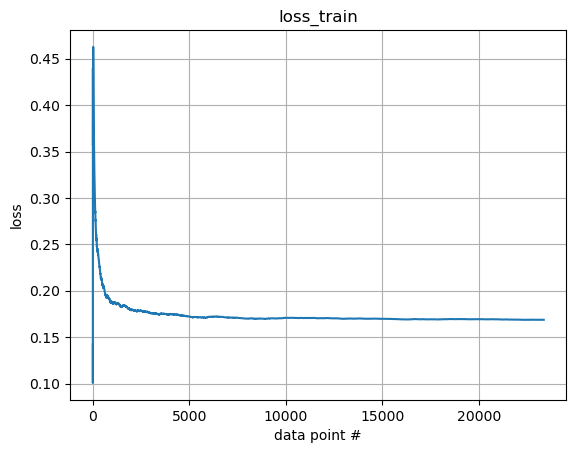

In [665]:
plt.plot(loss_train)
plt.title('loss_train')
plt.ylabel('loss')
plt.xlabel('data point #')
plt.grid(True)
plt.show()

# Inference on Held-Out Data

In [684]:
# inference on held-out data'
import matplotlib.pyplot as plt

y_mes_test = []
y_pred_test = []
metric = metrics.MAE()
rmse = metrics.RMSE()
# load
with open('data/model.pkl', 'rb') as f:
    model = pickle.load(f)
mae = []
mse = []
for index, row  in df_test.iterrows():
    x_test = Convert(embedding2(ast.literal_eval(row["embedding"])).flatten().tolist())
    y_test = row["Kd"]
    y_pred = model.predict_one(x_test)
    metric = metric.update(y_true=y_test, y_pred=y_pred)
    rmse = rmse.update(y_true=y_test, y_pred=y_pred)
    y_mes_test.append(y_test)
    y_pred_test.append(y_pred)
    mae.append(metric.get()) #.numpy()[0][0])
    mse.append(rmse.get()) #.numpy()[0][0])
print(f'MAE: {sum(mae)/len(mae):.2f}')
print(f'RMSE: {sum(mse)/len(mse):.2f}')
#plt.plot(mae)
#plt.title('MAE on held-out data')
#plt.show()


MAE: 0.12
RMSE: 0.16


In [683]:
metric.get()

0.08504190915734922

In [667]:
print("Pearson Correlation, Test Data: %.2f" %(np.corrcoef(y_mes_test,y_pred_test)[0,1]))

Pearson Correlation, Test Data: 0.16
